In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import pandas as pd
import os
import time
from datetime import timedelta
import rasterio.warp as rasteriowarp

In [2]:
SATELLITE_DATA_PATH = os.path.expanduser('~/data/EUMETSAT/reprojected_subsetted/')
PV_DATA_FILENAME = os.path.expanduser('~/data/pvoutput.org/UK_PV_timeseries_batch.nc')
PV_METADATA_FILENAME = os.path.expanduser('~/data/pvoutput.org/UK_PV_metadata.csv')

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Geospatial boundary in Transverse Mercator projection (meters)
SOUTH = 5513500
NORTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id')
pv_metadata.dropna(subset=['longitude', 'latitude'], how='any', inplace=True)

In [4]:
# Convert lat lons to Transverse Mercator
pv_metadata['x'], pv_metadata['y'] = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y <= NORTH) &
    (pv_metadata.y >= SOUTH)]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 13 s, sys: 2.23 s, total: 15.2 s
Wall time: 15.4 s


In [6]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2018-06-01', '2019-07-01'))]

In [7]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]
pv_power_df = pv_power_df.tz_localize('Europe/London').tz_convert('UTC')

In [8]:
del pv_power
del pv_power_selected

In [9]:
# A bit of hand-crafted cleaning
pv_power_df[30248]['2018-10-29':'2019-01-03'] = np.NaN

In [10]:
# Only pick PV systems for which we have good metadata
def align_pv_system_ids(pv_metadata, pv_power_df):
    pv_system_ids = pv_metadata.index.intersection(pv_power_df.columns)
    pv_system_ids = np.sort(pv_system_ids)

    pv_power_df = pv_power_df[pv_system_ids]
    pv_metadata = pv_metadata.loc[pv_system_ids]
    return pv_metadata, pv_power_df
    
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

In [11]:
# Scale to the range [0, 1]
pv_power_min = pv_power_df.min()
pv_power_max = pv_power_df.max()

pv_power_df -= pv_power_min
pv_power_df /= pv_power_max

In [12]:
# Drop systems which are producing over night
NIGHT_YIELD_THRESHOLD = 0.4
night_hours = list(range(21, 24)) + list(range(0, 4))
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > NIGHT_YIELD_THRESHOLD).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
print(len(bad_systems), 'bad systems found.')

#ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
#ax.set_title('Bad PV systems');

31 bad systems found.


In [13]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [14]:
%%time
# Interpolate up to 15 minutes ahead.
pv_power_df = pv_power_df.interpolate(limit=3)

CPU times: user 22 s, sys: 201 ms, total: 22.2 s
Wall time: 22.2 s


In [15]:
# Align again, after removing dud PV systems
pv_metadata, pv_power_df = align_pv_system_ids(pv_metadata, pv_power_df)

In [16]:
len(pv_power_df.columns)

913

In [17]:
#pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [18]:
pv_power_df.head()

,690,709,973,1364,1556,1627,1646,1647,1872,1883,...,67769,67927,67933,67948,67969,68000,68212,68218,68219,68324
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-01 02:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:35:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:45:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-06-01 02:50:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Load satellite data

In [19]:
from glob import glob
from torch.utils.data import Dataset
from datetime import datetime

In [20]:
RECTANGLE_WIDTH_M = 128000 # in meters
RECTANGLE_HEIGHT_M = RECTANGLE_WIDTH_M

METERS_PER_PIXEL = 1000
RECTANGLE_WIDTH_PIXELS = np.int(RECTANGLE_WIDTH_M / METERS_PER_PIXEL)
RECTANGLE_HEIGHT_PIXELS = np.int(RECTANGLE_HEIGHT_M / METERS_PER_PIXEL)

SAT_IMAGE_MEAN = 20.444992
SAT_IMAGE_STD = 8.766013


def get_rectangle(data_array, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
    half_width = width / 2
    half_height = height / 2

    north = centre_y + half_height
    south = centre_y - half_height
    east = centre_x + half_width
    west = centre_x - half_width

    return data_array.loc[dict(
        x=slice(west, east), 
        y=slice(north, south))]


class SatelliteLoader(Dataset):
    """
    Attributes:
        index: pd.Series which maps from UTC datetime to full filename of satellite data.
        _data_array_cache: The last lazily opened xr.DataArray that __getitem__ was asked to open.
            Useful so that we don't have to re-open the DataArray if we're asked to get
            data from the same file on several different calls.
    """
    def __init__(self, file_pattern):
        self._load_sat_index(file_pattern)
        self._data_array_cache = None
        self._last_filename_requested = None
        
    def __getitem__(self, dt: datetime) -> xr.DataArray:
        """Returns lazily-opened DataArray"""
        sat_filename = self.index[dt]
        if sat_filename != self._last_filename_requested:
            self._data_array_cache = xr.open_dataarray(sat_filename)
            self._last_filename_requested = sat_filename
        return self._data_array_cache.sel(time=dt)
    
    def close(self):
        if self._data_array_cache is not None:
            self._data_array_cache.close()
        
    def __len__(self):
        return len(self.index)
        
    def _load_sat_index(self, file_pattern):
        """Opens all satellite files in `file_pattern` and loads all their datetime indicies into self.index."""
        sat_filenames = glob(file_pattern)
        sat_filenames.sort()
        
        n_filenames = len(sat_filenames)
        sat_index = []
        for i_filename, sat_filename in enumerate(sat_filenames):
            if i_filename % 10 == 0 or i_filename == (n_filenames - 1):
                print('\r {:5d} of {:5d}'.format(i_filename + 1, n_filenames), end='', flush=True)
            data_array = xr.open_dataarray(sat_filename, drop_variables=['x', 'y'])
            sat_index.extend([(sat_filename, t) for t in data_array.time.values])

        sat_index = pd.DataFrame(sat_index, columns=['filename', 'datetime']).set_index('datetime').squeeze()
        assert not any(sat_index.index.duplicated())
        self.index = sat_index.tz_localize('UTC')
        
    def get_rectangles_for_all_data(self, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
        """Iterate through all satellite filenames and load rectangle of imagery."""
        sat_filenames = np.sort(np.unique(self.index.values))
        for sat_filename in sat_filenames:
            data_array = xr.open_dataarray(sat_filename)
            yield get_rectangle(data_array, time, centre_x, centre_y, width, height)
        
    def get_rectangle(self, time, centre_x, centre_y, width=RECTANGLE_WIDTH_M, height=RECTANGLE_HEIGHT_M):
        data_array = self[time]
        return get_rectangle(data_array, centre_x, centre_y, width, height)

In [21]:
%%time
sat_loader = SatelliteLoader(os.path.join(SATELLITE_DATA_PATH, '*.nc'))
print()

  3815 of  3815
CPU times: user 13.5 s, sys: 442 ms, total: 13.9 s
Wall time: 14.6 s


In [22]:
len(sat_loader)

45745

## Plot a test

In [23]:
# Test get rectangle
dt = pd.Timestamp('2019-02-21 10:15')
pv_system_id = pv_metadata.index[1]
x, y = pv_metadata.loc[pv_system_id][['x', 'y']]

In [24]:
%%time
sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y) #, width=512000, height=512000)

CPU times: user 8.81 ms, sys: 68 µs, total: 8.88 ms
Wall time: 7.94 ms


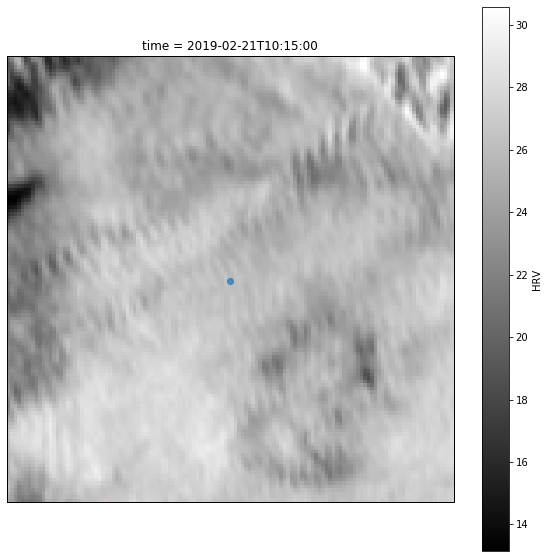

In [25]:
fig = plt.figure(figsize=(10, 10))
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', add_colorbar=True)
ax.scatter(x=x, y=y, alpha=0.7);

## Test clearsky

In [26]:
import pvlib
from pvlib.location import Location

In [27]:
def get_pvlib_location(pv_system_id):
    return Location(
        latitude=pv_metadata['latitude'][pv_system_id],
        longitude=pv_metadata['longitude'][pv_system_id],
        tz='UTC',
        name=pv_metadata['system_name'][pv_system_id])

location = get_pvlib_location(pv_system_id)
location

Location: 
  name: Grove Cottages
  latitude: 51.485329
  longitude: -0.967526
  altitude: 0
  tz: UTC

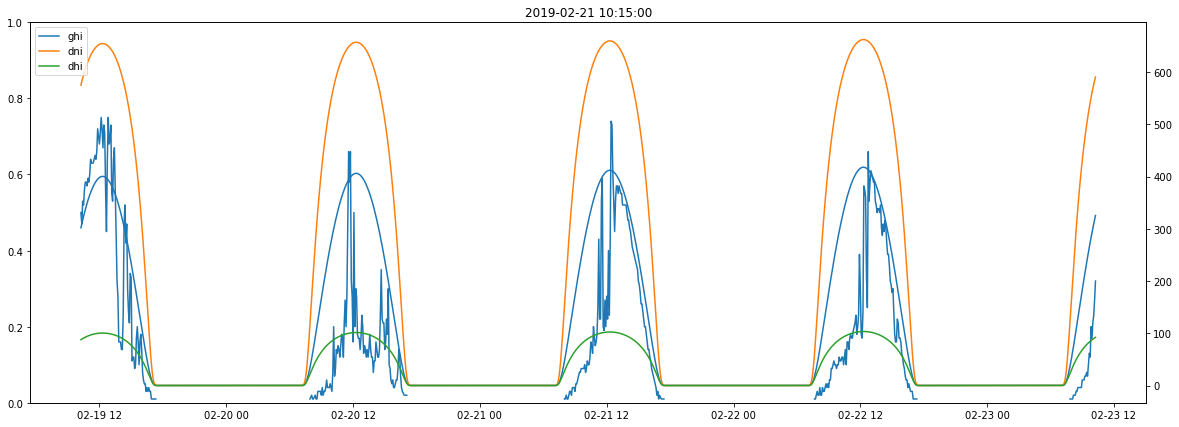

In [28]:
fig, ax = plt.subplots(figsize=(20, 7))
pv_data_to_plot = pv_power_df[pv_system_id][dt - timedelta(hours=48):dt + timedelta(hours=48)]
ax.plot(pv_data_to_plot, label='PV yield')
#ax.plot((dt, dt), (0, 1), linewidth=1, color='black', label='datetime of image above')
ax.set_title(dt)
ax.set_ylim((0, 1))

ax2 = ax.twinx()
clearsky = location.get_clearsky(pv_data_to_plot.index)
lines = ax2.plot(clearsky)
for line, label in zip(lines, clearsky.columns):
    line.set_label(label);
ax2.legend(loc='upper left');

## Align satellite datetime index with PV datetime index

In [29]:
datetime_index = pv_power_df.index.intersection(sat_loader.index.index)

In [30]:
# Filter by datetimes when sun is shining!
daylight_mask = location.get_clearsky(datetime_index)['ghi'] > 0
datetime_index = datetime_index[daylight_mask]

In [31]:
pv_power_df = pv_power_df.reindex(datetime_index)

In [32]:
len(datetime_index)

33326

In [33]:
datetime_index.tz

<UTC>

In [34]:
# Split train & test by days
days = np.unique(datetime_index.date)
len(days)

211

In [35]:
# Use every 5th day for testing
testing_days = days[::5]
len(testing_days)

43

In [36]:
training_days = np.array(list(set(days) - set(testing_days)))
training_days = np.sort(training_days)
len(training_days)

168

In [37]:
def get_datetime_index_for_days(training_or_testing_days):
    return datetime_index[pd.Series(datetime_index.date).isin(training_or_testing_days)]

training_datetimes = get_datetime_index_for_days(training_days)
testing_datetimes = get_datetime_index_for_days(testing_days)
assert not set(training_datetimes).intersection(testing_datetimes)

len(training_datetimes), len(testing_datetimes)

(26553, 6773)

### Load testing batch

In [38]:
import torch

In [39]:
def new_full_array(size, fill_value=np.NaN, dtype=np.float16):
    return np.full(shape=size, fill_value=fill_value, dtype=dtype)

In [40]:
TESTING_BATCH_SIZE = 256

In [41]:
testing_batch = {
    'sat_images': new_full_array(
        size=(TESTING_BATCH_SIZE, 1, RECTANGLE_WIDTH_PIXELS, RECTANGLE_HEIGHT_PIXELS),
        dtype=np.float32),  # use float32 to minimise problems with normalisation
    'pv_yield': new_full_array(
        size=(TESTING_BATCH_SIZE, 1)),
    'pv_system_id': np.zeros(shape=TESTING_BATCH_SIZE, dtype=np.int32),
    'datetime_index': testing_datetimes[:TESTING_BATCH_SIZE]}

In [42]:
for i, dt in enumerate(testing_batch['datetime_index']):
    # Randomly sample from PV systems which have data for this datetime
    pv_data_for_dt = pv_power_df.loc[dt].dropna()
    pv_system_id = np.random.choice(pv_data_for_dt.index)
    pv_yield = pv_data_for_dt[pv_system_id]
    
    # Load satellite image
    x, y = pv_metadata.loc[pv_system_id][['x', 'y']]
    sat_data = sat_loader.get_rectangle(time=dt, centre_x=x, centre_y=y)
    
    # Put into super batch
    testing_batch['sat_images'][i, 0] = sat_data.values
    testing_batch['pv_yield'][i, 0] = pv_yield
    testing_batch['pv_system_id'][i] = pv_system_id

In [43]:
# Normalise satellite images
testing_batch['sat_images'] -= SAT_IMAGE_MEAN
testing_batch['sat_images'] /= SAT_IMAGE_STD

## Load training super batch

In [44]:
N_RECTANGLES_PER_SAT_IMAGE = 32
N_DATETIMES_PER_SUPERBATCH = 4096

SUPER_BATCH_SIZE = N_RECTANGLES_PER_SAT_IMAGE * N_DATETIMES_PER_SUPERBATCH
BYTES_PER_PIXEL = 2  # float16
size_of_each_image_mb = (RECTANGLE_HEIGHT_PIXELS * RECTANGLE_WIDTH_PIXELS * BYTES_PER_PIXEL) / 1E6
super_batch_size_mb = size_of_each_image_mb * SUPER_BATCH_SIZE
print('Size of super batch: {:8.1f} MB'.format(super_batch_size_mb))
print('                     {:6d}   examples'.format(SUPER_BATCH_SIZE))

Size of super batch:   4295.0 MB
                     131072   examples


### Load CPU super batch from individual images

In [45]:
%%time
cpu_super_batch = {
    'sat_images': new_full_array(
        size=(SUPER_BATCH_SIZE, 1, RECTANGLE_WIDTH_PIXELS, RECTANGLE_HEIGHT_PIXELS), 
        dtype=np.float32),  # use float32 to minimise issues with normalisation
    'pv_yield': new_full_array(
        size=(SUPER_BATCH_SIZE, 1)),
    'pv_system_id': np.zeros(shape=SUPER_BATCH_SIZE, dtype=np.int32),
    'datetime_index': np.zeros(shape=SUPER_BATCH_SIZE, dtype='datetime64[s]')}

CPU times: user 145 ms, sys: 996 ms, total: 1.14 s
Wall time: 1.15 s


In [201]:
HALF_RECTANGLE_WIDTH_M = RECTANGLE_WIDTH_M / 2
HALF_RECTANGLE_HEIGHT_M = RECTANGLE_HEIGHT_M / 2

def load_data_into_cpu_super_batch():
    # Get datetimes for superbatch by randomly sampling
    super_batch_datetimes = np.random.choice(training_datetimes.to_numpy(dtype=object), size=N_DATETIMES_PER_SUPERBATCH)
    super_batch_datetimes = np.sort(super_batch_datetimes)
    super_batch_datetimes = pd.DatetimeIndex(super_batch_datetimes)
    cpu_super_batch['datetime_index'] = np.zeros(shape=SUPER_BATCH_SIZE, dtype='datetime64[s]')
    
    # Load satellite data and PV data
    for image_i, dt in enumerate(super_batch_datetimes):
        print('\r{:6d} of {:d}'.format(image_i+1, N_DATETIMES_PER_SUPERBATCH), end='', flush=True)

        # Randomly sample from PV systems which have data for this datetime
        # Loop because we sat images (very rarely) have NaNs, in which case we need to pick another random datetime
        while True:
            pv_data_for_dt = pv_power_df.loc[dt].dropna()
            replace = len(pv_data_for_dt) < N_RECTANGLES_PER_SAT_IMAGE
            pv_system_ids = np.random.choice(pv_data_for_dt.index, size=N_RECTANGLES_PER_SAT_IMAGE, replace=replace)
            locations = pv_metadata.loc[pv_system_ids][['x', 'y']]

            # Get bounding box
            north = locations['y'].max() + HALF_RECTANGLE_HEIGHT_M
            south = locations['y'].min() - HALF_RECTANGLE_HEIGHT_M
            west = locations['x'].min() - HALF_RECTANGLE_WIDTH_M
            east = locations['x'].max() + HALF_RECTANGLE_WIDTH_M

            # Load satellite images
            # Very rarely images are NaN, so we need to handle that case
            data_array = sat_loader[dt]
            data_array = data_array.loc[dict(
                x=slice(west, east), 
                y=slice(north, south))]
            data_array = data_array.load()
            
            if np.any(np.isnan(data_array.values)):
                print('\nSat image for', dt, 'has NaNs!  Picking another datetime!')
                dt = np.random.choice(training_datetimes.to_numpy(dtype=object))
            else:
                break                 

        example_i = image_i * N_RECTANGLES_PER_SAT_IMAGE
        for pv_system_id, row in locations.iterrows():
            sat_data = get_rectangle(data_array, centre_x=row.x, centre_y=row.y)
            pv_yield = pv_data_for_dt[pv_system_id]

            # Put into super batch
            cpu_super_batch['sat_images'][example_i, 0] = sat_data.values
            cpu_super_batch['pv_yield'][example_i, 0] = pv_yield
            cpu_super_batch['pv_system_id'][example_i] = pv_system_id
            cpu_super_batch['datetime_index'][example_i] = dt.to_numpy()  # TODO: Maybe move this to a vectorised solution?
            example_i += 1
            
    cpu_super_batch['datetime_index'] = pd.DatetimeIndex(cpu_super_batch['datetime_index'], tz='UTC')

    # Normalise satellite images
    cpu_super_batch['sat_images'] -= SAT_IMAGE_MEAN
    cpu_super_batch['sat_images'] /= SAT_IMAGE_STD

    print()
    return cpu_super_batch

In [202]:
%%time
cpu_super_batch = load_data_into_cpu_super_batch()

  4096 of 4096
CPU times: user 4min 29s, sys: 14.4 s, total: 4min 44s
Wall time: 5min 3s


### Compute hour of day and clearsky

In [204]:
HOURS_OF_DAY_MEAN = 11.628418
HOURS_OF_DAY_STD = 4.1584363

def compute_hour_of_day(batch_dict):
    hours_of_day = batch_dict['datetime_index'].hour.values.astype(np.float32)
    hours_of_day -= HOURS_OF_DAY_MEAN
    hours_of_day /= HOURS_OF_DAY_STD
    batch_dict['hours_of_day'] = hours_of_day[:, np.newaxis]
    return batch_dict

In [205]:
cpu_super_batch = compute_hour_of_day(cpu_super_batch)

In [51]:
testing_batch = compute_hour_of_day(testing_batch)

#### Clearsky

In [206]:
CLEARSKY_MEAN = np.array([373.1623 , 538.70374,  80.82757], dtype=np.float32)
CLEARSKY_STD = np.array([268.6872  , 254.62102 ,  42.651264], dtype=np.float32)

def compute_clearsky(batch_dict):
    n_examples = len(batch_dict['datetime_index'])
    clearsky = np.full(shape=(n_examples, 3), fill_value=np.NaN, dtype=np.float32)
    pv_ids_and_datetimes = pd.DataFrame(
        {'pv_system_id': batch_dict['pv_system_id'], 
         'datetime_index': batch_dict['datetime_index']})
    
    for pv_system_id, df in pv_ids_and_datetimes.groupby('pv_system_id'):
        dt_index = pd.DatetimeIndex(df['datetime_index'])
        location = get_pvlib_location(pv_system_id)
        clearsky_for_location = location.get_clearsky(dt_index)
        clearsky[df.index] = clearsky_for_location.values

    assert not any(np.isnan(clearsky).flatten())
    
    clearsky -= CLEARSKY_MEAN
    clearsky /= CLEARSKY_STD
    
    batch_dict['clearsky'] = clearsky
    return batch_dict

In [207]:
%%time
cpu_super_batch = compute_clearsky(cpu_super_batch)

CPU times: user 19.6 s, sys: 138 ms, total: 19.7 s
Wall time: 19.8 s


In [54]:
%%time
testing_batch = compute_clearsky(testing_batch)

CPU times: user 4.4 s, sys: 2.45 ms, total: 4.41 s
Wall time: 4.41 s


## Check 

In [215]:
def check_super_batch(batch_dict):
    dict_keys_with_nans = []
    for k, v in batch_dict.items():
        if k != 'datetime_index' and np.any(np.isnan(v)):
            dict_keys_with_nans.append(k)
    if dict_keys_with_nans:
        raise ValueError('These super batch keys have NaNs!  {}'.format(dict_keys_with_nans))

In [216]:
check_super_batch(cpu_super_batch)

In [ ]:
check_super_batch(testing_batch)

### GPU super batch

In [55]:
from copy import copy

In [56]:
def new_full_tensor(size, fill_value=np.NaN, dtype=torch.float16, device='cuda'):
    return torch.full(size=size, fill_value=fill_value, dtype=dtype, device=device)

In [57]:
%%time
gpu_super_batch = {
    'sat_images': new_full_tensor(
        size=(SUPER_BATCH_SIZE, 1, RECTANGLE_WIDTH_PIXELS, RECTANGLE_HEIGHT_PIXELS)),
    'pv_yield': new_full_tensor(size=(SUPER_BATCH_SIZE, 1)),
    'hours_of_day': new_full_tensor(size=(SUPER_BATCH_SIZE, 1)),
    'clearsky': new_full_tensor(size=(SUPER_BATCH_SIZE, 3))
}

CPU times: user 1.6 s, sys: 141 ms, total: 1.75 s
Wall time: 1.79 s


In [217]:
def move_superbatch_to_gpu(cpu_super_batch):
    for k, v in cpu_super_batch.items():
        if k in ['datetime_index', 'pv_system_id']:
            gpu_super_batch[k] = copy(v)
        else:
            try:
                gpu_super_batch[k].copy_(torch.HalfTensor(v))
            except:
                print('Problem with', k)
                raise

    return gpu_super_batch

In [218]:
%%time
gpu_super_batch = move_superbatch_to_gpu(cpu_super_batch)

CPU times: user 2.65 s, sys: 1.91 s, total: 4.57 s
Wall time: 1.14 s


In [219]:
gpu_super_batch.keys()

dict_keys(['sat_images', 'pv_yield', 'hours_of_day', 'clearsky', 'pv_system_id', 'datetime_index'])

In [61]:
# Move testing batch into GPU memory
for key in ['sat_images', 'pv_yield', 'hours_of_day', 'clearsky']:
    testing_batch[key] = torch.cuda.HalfTensor(testing_batch[key])

## Define neural net

In [62]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [159]:
class Net(nn.Module):
    def __init__(self, dropout_proportion=0.1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=12, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=16, kernel_size=5)
        HOURS_OF_DAY_CHANNELS = 1
        CLEARSKY_CHANNELS = 3
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120 + HOURS_OF_DAY_CHANNELS + CLEARSKY_CHANNELS, 84)
        self.fc3 = nn.Linear(84, 1)
        self.dropout_layer = nn.Dropout(p=dropout_proportion)

    def forward(self, x, hour_of_day, clearsky):
        #x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv1(x)))
        # x is now <batch_size>, 6, 62, 62.  
        # 62 is 124 / 2.  124 is the 128-dim input - 4
        x = self.dropout_layer(x)
        x = self.pool(F.relu(self.conv2(x)))
        # x is now <batch_size>, 16, 29, 29
        x = x.view(-1, 16 * 29 * 29)
        # x is now <batch_size>, 16 x 29 x 29
        x = self.dropout_layer(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_layer(x)
        x = torch.cat((x, hour_of_day, clearsky), dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net().cuda().half()

In [160]:
optimizer = optim.SGD(net.parameters(), lr=0.01)
loss_func = nn.MSELoss()
mae_loss_func = nn.L1Loss()

In [161]:
train_losses = []
train_mae_losses = []
test_losses = []
test_mae_losses = []

training_index_len_minus_1 = SUPER_BATCH_SIZE - 1

In [162]:
TRAINING_BATCH_SIZE = 128

BATCHES_PER_EPOCH = int(SUPER_BATCH_SIZE / TRAINING_BATCH_SIZE)
STATS_PERIOD = int(BATCHES_PER_EPOCH / 4)
N_EPOCHS = 7
N_LOADS = 7
N_BATCHES_TO_TRAIN = BATCHES_PER_EPOCH * N_EPOCHS

TESTING_INPUTS = testing_batch['sat_images']
TESTING_TARGET = testing_batch['pv_yield']
TESTING_HOURS_OF_DAY = testing_batch['hours_of_day']
TESTING_CLEARSKY = testing_batch['clearsky']

In [ ]:
%%time

achieved_good_test_mae = False

for i_load in range(N_LOADS):
    print('loading', i_load, 'of', N_LOADS)
    t0 = time.time()
    running_train_loss = 0.0
    running_train_mae = 0.0
    for i_batch in range(N_BATCHES_TO_TRAIN):
        print('\rBatch: {:4d} of {}'.format(i_batch + 1, N_BATCHES_TO_TRAIN), end='', flush=True)

        # Create batch
        batch_index = np.random.randint(low=0, high=training_index_len_minus_1, size=TRAINING_BATCH_SIZE)
        inputs = gpu_super_batch['sat_images'][batch_index]
        hours_of_day_for_batch = gpu_super_batch['hours_of_day'][batch_index]
        clearsky_for_batch = gpu_super_batch['clearsky'][batch_index]
        target = gpu_super_batch['pv_yield'][batch_index]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        net.train()
        outputs = net(inputs, hours_of_day_for_batch, clearsky_for_batch)
        train_loss = loss_func(outputs, target)
        train_loss.backward()
        optimizer.step()
        running_train_loss += train_loss.item()

        # MAE
        train_mae = mae_loss_func(outputs, target)
        running_train_mae += train_mae.item()

        # print statistics
        if i_batch == 0 or i_batch % STATS_PERIOD == STATS_PERIOD - 1:    # print every STATS_PERIOD mini-batches
            t1 = time.time()

            # Train loss
            if i_batch == 0:
                mean_train_loss = running_train_loss
                mean_train_mae = running_train_mae
            else:
                mean_train_loss = running_train_loss / STATS_PERIOD
                mean_train_mae = running_train_mae / STATS_PERIOD

            train_losses.append(mean_train_loss)
            train_mae_losses.append(mean_train_mae)

            # Test loss
            net.eval()
            test_outputs = net(TESTING_INPUTS, TESTING_HOURS_OF_DAY, TESTING_CLEARSKY)
            test_loss = loss_func(test_outputs, TESTING_TARGET).item()
            test_losses.append(test_loss)
            test_mae = mae_loss_func(test_outputs, TESTING_TARGET).item()
            test_mae_losses.append(test_mae)

            print(
                '\n        time =   {:.2f} milli seconds per batch.\n'
                '   train loss = {:8.5f}\n'
                '    train MAE = {:8.5f}\n'
                '    test loss = {:8.5f}\n'
                '     test MAE = {:8.5f}'.format(
                    ((t1 - t0) / STATS_PERIOD) * 1000,
                    mean_train_loss, 
                    mean_train_mae,
                    test_loss,
                    test_mae
                ))
            running_train_loss = 0.0
            running_train_mae = 0.0
            t0 = time.time()
            
            # Break if test MAE suddenly spikes up
            if test_mae < 0.10:
                achieved_good_test_mae = True
            if achieved_good_test_mae and test_mae > 0.11:
                print('Eak!  Test MAE has spiked up!')
                break
          
    print()
    if i_load < N_LOADS - 1:
        print('Loading new data!')
        cpu_super_batch = load_data_into_cpu_super_batch()
        cpu_super_batch = compute_hour_of_day(cpu_super_batch)
        cpu_super_batch = compute_clearsky(cpu_super_batch)
        check_super_batch(cpu_super_batch)
        gpu_super_batch = move_superbatch_to_gpu(cpu_super_batch)

print()
print('Finished Training')

loading 0 of 7
Batch:    1 of 7168
        time =   0.44 milli seconds per batch.
   train loss =  0.01875
    train MAE =  0.09692
    test loss =  0.01643
     test MAE =  0.08539
Batch:  256 of 7168
        time =   15.32 milli seconds per batch.
   train loss =  0.01770
    train MAE =  0.09062
    test loss =  0.01625
     test MAE =  0.08527
Batch:  512 of 7168
        time =   15.33 milli seconds per batch.
   train loss =  0.01773
    train MAE =  0.09088
    test loss =  0.01665
     test MAE =  0.08636
Batch:  768 of 7168
        time =   15.95 milli seconds per batch.
   train loss =  0.01784
    train MAE =  0.09085
    test loss =  0.01642
     test MAE =  0.08508
Batch: 1024 of 7168
        time =   15.83 milli seconds per batch.
   train loss =  0.01760
    train MAE =  0.09066
    test loss =  0.01624
     test MAE =  0.08539
Batch: 1252 of 7168

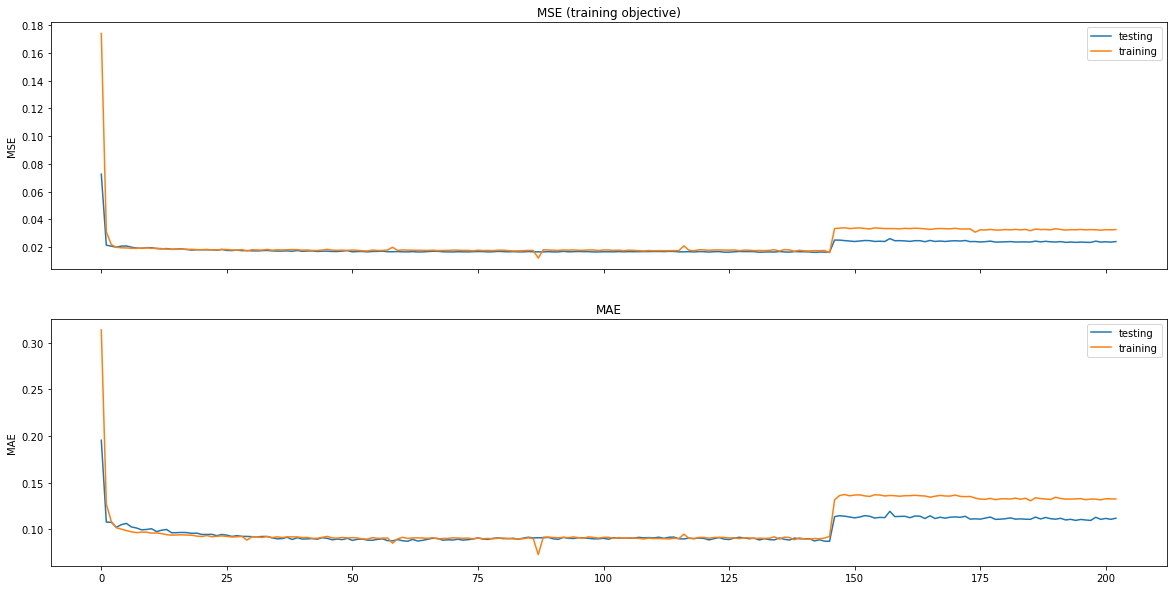

In [68]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(20, 10))

ax1.plot(test_losses, label='testing')
ax1.plot(train_losses, label='training')
ax1.set_title('MSE (training objective)')
ax1.set_ylabel('MSE')
ax1.legend()

ax2.plot(test_mae_losses, label='testing')
ax2.plot(train_mae_losses, label='training')
ax2.set_title('MAE')
ax2.set_ylabel('MAE')
ax2.legend();

In [107]:
batch_index

array([  3808, 108158,    162,   1649,  67145,  88775,  77782, 114239,
        89811,  86382, 114667,  83025,  80282,   4666,  68384, 104169,
        71993,  40385,  30086,  33125,   3278,  32810,  44640,  74900,
        27876, 109993,  51833,  81930, 129005,  47062,  72656,  87780,
        88125,  75941,  29164, 115181,  91587, 125806,   4951,  55520,
        92346,  61820,  13504,  30527, 101219,  99692,  66656,  12876,
        23168,  20828,  78705,  41502,  67339,  87161,  60740, 106596,
        80683,  54113,  51583,  13905,  56687,  22440,  14151,  66227,
        43337,   9752,  53509,   6048,  46254,  69952,   6185,   8459,
        72236,  44242, 116244, 107289,   6889,  73117,  31175, 119950,
        61123,  79554,  55712,  23440,  13093,  89286,   9515,  78858,
       102884,  89302,  46340,    183,  85521, 123128,  77705, 124985,
       129763,  27455,  50871,  31753,  59933,  80453,  38693,  64625,
        36834,  54766,  79613,    959,  16827,  95183,  87779, 105309,
      

In [110]:
gpu_super_batch['datetime_index'][batch_index]

DatetimeIndex(['2018-06-05 16:05:00+00:00', '2019-05-29 18:45:00+00:00',
               '2018-06-02 06:20:00+00:00', '2018-06-03 10:00:00+00:00',
               '2019-04-02 11:10:00+00:00', '2019-05-04 09:25:00+00:00',
               '2019-04-18 16:45:00+00:00', '2019-06-07 13:55:00+00:00',
               '2019-05-04 19:00:00+00:00', '2019-04-30 15:05:00+00:00',
               ...
               '2019-01-10 08:20:00+00:00', '2019-02-02 08:55:00+00:00',
               '2019-05-04 12:20:00+00:00', '2019-06-16 17:55:00+00:00',
               '2019-04-03 15:25:00+00:00', '2018-06-03 08:25:00+00:00',
               '2019-06-29 12:55:00+00:00', '2019-04-24 10:15:00+00:00',
               '2019-01-23 08:15:00+00:00', '2019-05-10 13:45:00+00:00'],
              dtype='datetime64[ns, UTC]', length=128, freq=None)

False

Timestamp('2019-06-07 13:55:00+0000', tz='UTC')

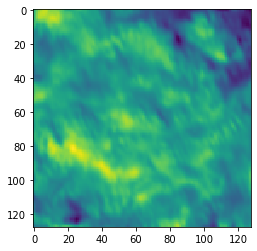

In [126]:
i = 7
plt.imshow(cpu_super_batch['sat_images'][batch_index][i, 0].astype(np.float32))
dt = cpu_super_batch['datetime_index'][batch_index]
dt[i]

In [127]:
cpu_super_batch['sat_images'][batch_index][i, 0].mean()

4.267365

In [128]:
cpu_super_batch['pv_yield'][batch_index][i, 0]

0.11053

In [130]:
cpu_super_batch['clearsky'][batch_index][i]

array([1.4208038, 0.9451693, 1.2293992], dtype=float32)

In [133]:
cpu_super_batch['hours_of_day'][batch_index][i, 0]

0.3298312

In [138]:
np.corrcoef(cpu_super_batch['pv_yield'][:, 0], cpu_super_batch['clearsky'][:, 0])

array([[1.        , 0.64331078],
       [0.64331078, 1.        ]])

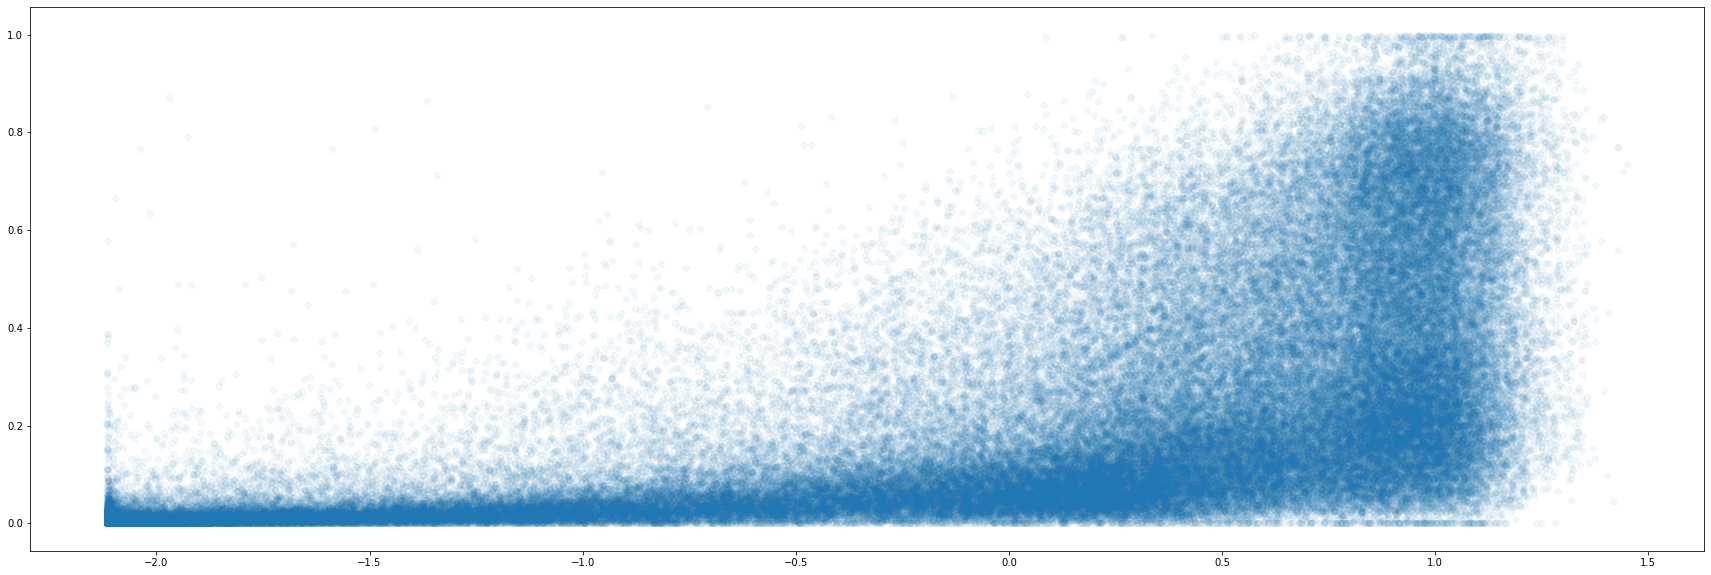

In [146]:
fig, ax = plt.subplots(figsize=(30, 10))

ax.scatter(
    cpu_super_batch['clearsky'][:, 1],
    cpu_super_batch['pv_yield'][:, 0],
    alpha=0.05);